# Fluence computation with NRLMSISE-00 Earth's atmospheric model
## *For circular orbits in LEO*

### Description

This Jupyter-notebook allows you to compute the total **fluence** of a space craft in LEO. It take into account the solar activity to have a better prediction of what will happen during each year of the mission.  
Several assumption are made to model the solar cycle and to compute densities; everything is explained in the report.  
To use this tool, you just need the file where are stored the Ap and F10.7 indexes since ~1960 and to know the **altitude**, the **beginning** year, the **duration** and the **inclination** of the SC.  
This tool doesn't take into account non-circular orbits and considers only Atomix Oxygen damages on SC.

### Import packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from nrlmsise00 import msise_flat         # Atmospheric model package
from IPython.display import clear_output
from astropy.io import ascii
from scipy import optimize
import bbox as bbox
plt.rcParams.update({'font.size': 14})    

#### *The first time you open the jupyter-notebook, don't forget to put the file*   "Ap_F10.7_indexes.txt"   *in the right folder and to run all cells in the annexe.*

### Input variable

The altitude must be between 0 and 1000km.   
As we use known values to fit solar activity, you can make prediction up to 2046 (more or less 2 solar cycle of predictions) with good accuracy.  
As we want to know the total fluence over several years, we average the ATOX density between the min and max latitude of our orbit.

In [9]:
alt               = float(input('Flight altitude (km) : '))
if alt>1000:
    print('      /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ \n  \n  \
    /!\ Your altitude is too high for the model  /!\  \n \n \
     /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ ')
ini_year          = int(input('Mission beginning year : '))
mission_duration  = int(input('Mission duration (year) : '))
if ini_year+mission_duration > 2046:
    print('      /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ \n  \n  \
    /!\ Your mission is too long for the model   /!\  \n \n \
     /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ ')
print('Be aware that the maximum latitude has to be between -90° and 90°. ')
max_lat           = float(input('Latitude max during mission (°N) : '))
if max_lat > 90:
    print('      /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ \n  \n  \
    /!\          -90° < max_lat < 90°            /!\  \n \n \
     /!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\/!\ ')

Flight altitude (km) : 876
Mission beginning year : 2025
Mission duration (year) : 18
Be aware that the maximum latitude has to be between -90° and 90°. 
Latitude max during mission (°N) : 50


### Calulation

You can change the precision of the spatial step, the number of day for each month, the number of hour a day 

In [10]:
alts      = np.arange(alt, alt+1, 2.)                 # define altitude
precision = 5.                                        # define computation step for lat and long (in deg)
lats      = np.arange(-max_lat, max_lat+1,precision)  # latitude range
longs     = np.arange(0, 361, precision)              # longitude range
 
yr    = [i+ini_year for i in range(mission_duration)] # time array (in year)
month = [i+1 for i in range(12)]                      # month array
day   = [8*i+1 for i in range(4)]                     # day array (here 2 days per month)
hour  = [2*(i) for i in range(12)]                    # hour array (here 12 hours per day)

# 8-dimension cube initialisation
data_test = np.zeros((len(yr),len(month), len(day),len(hour), len(lats), len(longs), len(alts),11))
# Time loop
for year in range(len(yr)):
    for m in range(len(month)):
        clear_output(wait=True)
        print('Calculation progression : ',int((year*len(month)+m+1) / (len(yr)*len(month)) *100),'%')
        for d in range(len(day)):
            for h in range(len(hour)):
                data_test[year,m,d,h] = msise_flat(datetime(yr[year],month[m] , day[d], hour[h], 0, 0),\
                                           alts[None, None, :], lats[:, None, None], longs[None, :, None],\
                                           give_F107(year+ini_year), give_F107(year+ini_year), Apmean)

Calculation progression :  100 %


You will have an estimation for the fluence for each year and an estimation for the total time.

Text(0.5, 0, 'Year')

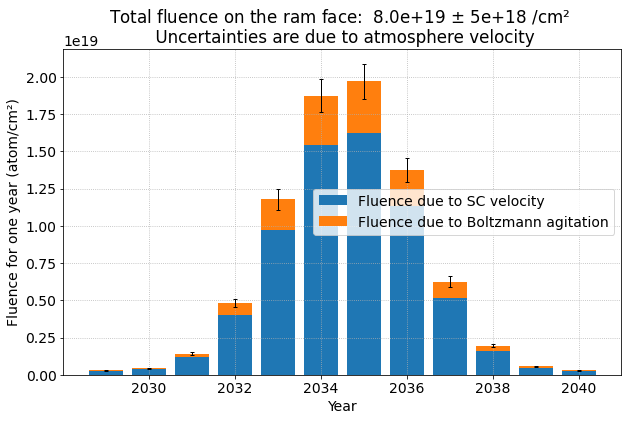

In [8]:
density = np.zeros(len(yr))       #Density array initialisation
# Computation of the mean density for each year
for i in range(len(yr)):
    density[i] = np.mean(data_test[i, :, :, :, :, :, :,1 ])
#With a 1 year step
d_spacecraft = density*7e5      # multiply by typical SC velocity
d_boltz      = density*1500e2   # multiply by typical thermal velocity
d_atm        = density*500e2    # multiply by typical atmosphere velocity  
yr_sec       = 365.25*24*3600   # A yr in second

fluence_spacecraft = d_spacecraft * yr_sec  # fluence due to SC velocity
fluence_boltz      = d_boltz * yr_sec       # fluence due to 
fluence_atm        = d_atm * yr_sec
#Total time
d_tot       = np.mean(density)
fluence_tot = d_tot*(7e5+1.5e5)*yr_sec*mission_duration # Fluence due to SC & Boltzmann speed
delta_ftot  = d_tot*(5e4)*yr_sec*mission_duration       # Uncertainties due to atm. velocity

plt.figure(1, figsize=(10,6))
plt.bar(yr,fluence_spacecraft, label='Fluence due to SC velocity' )
plt.bar(yr,fluence_boltz, bottom=fluence_spacecraft, label='Fluence due to Boltzmann agitation')
plt.errorbar(yr, fluence_boltz+fluence_spacecraft, yerr= fluence_atm,\
             ecolor = "black",capsize = 2,elinewidth = 1,capthick = 1,fmt="none")
plt.grid(ls=':')
plt.legend()
plt.title('Total fluence on the ram face:  %.1e $\pm$ %.0e /cm²  \n Uncertainties are due to atmosphere velocity' %(fluence_tot,delta_ftot))
plt.ylabel('Fluence for one year (atom/cm²)')
plt.xlabel('Year')
#plt.savefig('sentinel3_fluence.pdf')  # Save the plot


### Erosion estimation evolution for polymers

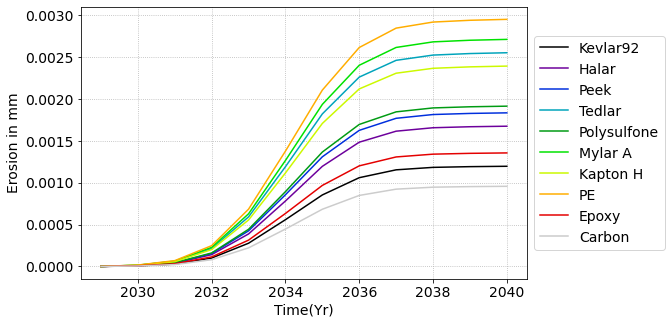

In [23]:
fluence_integree = np.zeros(len(yr))
# Compute at each year the total fluence up to this point :
for i in range(len(yr)-1):
    fluence_integree[i+1] = fluence_integree[i] +(fluence_spacecraft[i+1]+fluence_boltz[i+1])

er_poly = np.zeros((len(polymers), len(fluence_integree)))
color   = iter(plt.cm.nipy_spectral(np.linspace(0,1,len(polymers)))) #define set of color for teh plot

plt.figure(1, figsize=(8, 5))
for i in range(len(polymers)):
    er_poly[i] = fluence_integree*polymers[i]*1e-23
    c = next(color)
    plt.plot(yr, er_poly[i], c=c)
plt.grid(ls=':')
plt.xlabel('Time(Yr)')
plt.ylabel('Erosion in mm')
plt.legend(('Kevlar92', 'Halar', 'Peek', 'Tedlar', 'Polysulfone', 'Mylar A', 'Kapton H', 'PE',\
            'Epoxy', 'Carbon'), bbox_to_anchor=(1, 0.5), loc = 'center left')
plt.savefig('sentinel3_polyerosion.pdf', bbox_inches='tight')  # Save the plot

### Erosion estimation evolution for metals

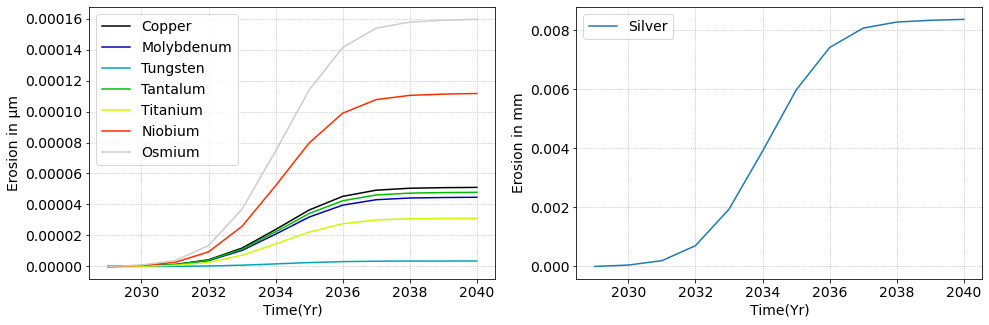

In [10]:
er_met = np.zeros((len(metals), len(fluence_integree)))
color=iter(plt.cm.nipy_spectral(np.linspace(0,1,len(metals)-1)))
plt.figure(1, figsize=(16, 5))
plt.subplot(121)
for i in range(len(metals)-1):
    er_met[i] = fluence_integree*metals[i]*1e-22
    c = next(color)
    plt.plot(yr, er_met[i], c=c)

plt.grid(ls=':')
plt.xlabel('Time(Yr)')
plt.ylabel('Erosion in µm')
plt.legend(('Copper', 'Molybdenum', 'Tungsten', 'Tantalum', 'Titanium', 'Niobium', 'Osmium'))
plt.subplot(122)
plt.plot(yr, fluence_integree*metals[-1]*1e-23, label='Silver')
plt.grid(ls=':')
plt.xlabel('Time(Yr)')
plt.ylabel('Erosion in mm')
plt.legend()
#plt.savefig('sentinel3_met_erosion.pdf')  # Save the plot

## Annexe

F10.7 prediction ( Solar index ). We have the value of the Solar index with the NRLMSISE-00 model website.  
I want to have a function that give me the value of the Solar index with respect to the year. 

For the magnetic index (Ap), as it has a cahotic behavior, we will take the mean value. We make integration over decades, so we are not intereted in the small fluctuations.

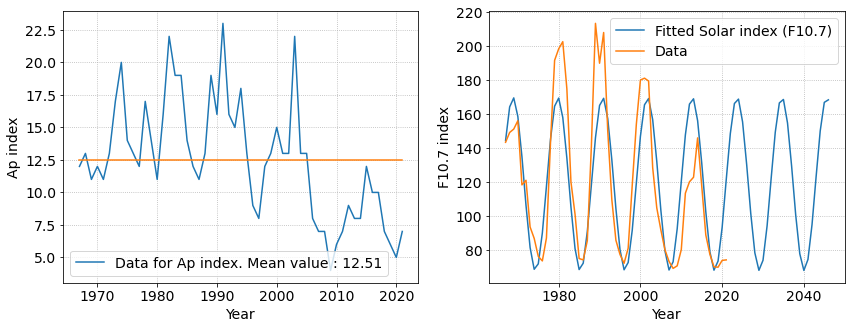

In [8]:
# Data for F10.7 and Ap index are stored in a folder available in the .zip file
data_sc = ascii.read('Ap_F10.7_indexes.txt') # Data from nasa website
yr_  = data_sc['col1']
F107 = data_sc['col5']
Ap = data_sc['col4']

#==============================
#Computing the mean value of Ap
#==============================
Apmean = np.mean(Ap)

#===========================================
# Fitting the F10.7 according to solar cycle
#===========================================
# Define a sinusoidal model for the data
def test_func(x, a, b, c, d):
    return a * np.sin(b * x+c)+d

# Adjust this model
params, params_covariance = optimize.curve_fit(test_func, yr_, F107,
                                               p0=[80, 0.5,150,1])

# Use this model to predict F10.7 value up to ~2045
yr_new = [i+1967 for i in range(80)]
F107_theo = np.zeros(len(yr_new))
for ii in range(len(yr_new)):
    F107_theo[ii] = test_func(yr_new[ii], params[0], params[1],params[2],params[3])
# Write a function to have direcly acces to the value of the solar index wrt the year
def give_F107(year):
    return F107_theo[year-1967] 


#================================
# Data to compute ersosion yields
#================================
#[Kevlar92, Halar, Peek, Tedlar, Polysulfone, Mylar A, Kapton H, PE, Epoxy, Carbon]
polymers = [1.5, 2.1, 2.3, 3.2, 2.4, 3.4, 3, 3.7, 1.7, 1.2] 

#[Copper, Molybdenum, Tungsten, Tantalum, Titanium, Niobium, Osmiumn, Silver]
metals = [0.0064, 0.0056, 0.00044, 0.006, 0.0039, 0.014, 0.02, 10.5]

#==============================================
#Plot the data, mean, and fitting to illustrate
#==============================================

Ap_mean = np.zeros(len(Ap))
for i in range(len(Ap)):
    Ap_mean[i] = np.mean(Ap)

plt.figure(1, figsize=(14, 5))
plt.subplot(121)
plt.plot(yr_,Ap, label='Data for Ap index. Mean value : %.2f' %np.mean(Ap))
plt.plot(yr_, Ap_mean)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Ap index')
plt.grid(ls=':')
plt.savefig('Ap.pdf')
plt.subplot(122)
plt.plot(yr_new,F107_theo, label='Fitted Solar index (F10.7)')
plt.plot(yr_,F107, label = 'Data')
plt.xlabel('Year')
plt.legend()
plt.ylabel('F10.7 index')
plt.savefig('Fit_F107.pdf')
plt.grid(ls=':')